In [82]:
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Evaluating the success of a marketing campaign

Company J (e-commerce) hired you as their first data analyst, about 3 years after they first started operations. Things are a little messy with regards to what has been tracked and what data is available. 

**Today's date is October 21, 2019**

The Marketing team ran a 3-week campaign to attract more traffic to the online shop with the hope of increasing revenue. 

The campaign ran from 2019-04-08 until 2019-04-28 (inclusive).

Now that the company hired you, they are interested in evaluating whether the campaign was a success or not as they're planning on running a similar one again within the next couple of months. The challenge, however, is that you only have access to pageview data for the landing page. Company J has worked with a data consultancy in the past and they were able to provide some estimates with regards to conversions that you can find below.

The goal of this lab is to guide you through working with vague requirements from stakeholders and only a handful of information. You start by taking a first look at the data to see if you can visually spot any meaningful variations. Following that, you are going to attempt to quantify the impact of the marketing campaign. Once you have some numbers, you will get access to a handful of additional data points that will support you in your conclusion. At the end, you will discuss your recommendation to the Marketing team with regards to the assumptions you had to make to get to your conclusion.

Plan:

1. Load and inspect the data
2. Estimate the pageviews without campaign
3. Compute difference in estimated (predicted) pageviews and actual pageviews
4. Use data points provided by data consultancy to estimate ROI (return on investment)
5. Conclude success of campaign

## 1. Load and inspect data

In [16]:
# load the csv into a pd.Dataframe and show a preview of the first rows
df = pd.read_csv(os.path.join("..", "data", "daily_pageviews.csv"))
df.head()

,date_id,page_name,pageviews
0,2018-12-31,landing_page,302878752
1,2019-01-01,landing_page,312601914
2,2019-01-02,landing_page,326949126
3,2019-01-03,landing_page,321689932
4,2019-01-04,landing_page,315004706


In [3]:
# check dtypes
df.dtypes

date_id      object
page_name    object
pageviews     int64
dtype: object

In [17]:
# convert `date_id` to a datetime type
df["date_id"] = pd.to_datetime(df["date_id"])

In [6]:
# set variables for the campaign start and end date as datetimes
campaign_start = pd.to_datetime("2019-04-08")
campaign_end = pd.to_datetime("2019-04-28")

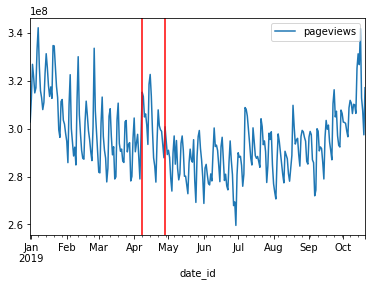

In [19]:
# plot daily pageview
ax = df.plot(x="date_id", y="pageviews", kind="line")
# add vertical lines in red according to the start date and end date of the marketing campaign
ax.axvline(campaign_start, color="r")
ax.axvline(campaign_end, color="r")

You should be able to visually detect a slight difference between the days during campaign and the surrounding days. However, there is too much noise on the graph when using daily resolution, so you want to look at weekly data.

To do so, you have to group your dataset by weeks and sum over pageview to get weekly pageviews.

**I. Create a new column with each date truncated to the first day of a week (Mo)**
1. For each `date_id`, retrieve the day of week as an `int`
2. Convert that `int` into a `Timedelta` type and specify to interpret the value as Days
3. Subtract that `Timedelta` from the `date_id`

In [45]:
# 1. For each `date_id`, retrieve the day in week as an `int` and store it in a column `day_of_week`
# For example, if `date_id = 2019-01-01`, then `day_of_week = 2 (or 1)` # for Tuesday
df["day_of_week"] = df["date_id"].dt.dayofweek
df["day_of_week"]

0      0
1      1
2      2
3      3
4      4
      ..
289    2
290    3
291    4
292    5
293    6
Name: day_of_week, Length: 294, dtype: int64

In [46]:
# 2. Convert `day_of_week` into a `Timedelta` type
df["day_of_week"] = pd.to_timedelta(df["day_of_week"], unit="days")

In [48]:
# 3. Subtract `day_of_week` from `date_id` and assign it as a new column `week_id`
# validate that you successfully truncated all `date_id`s to the first day of each week
df["week_id"] = df["date_id"]- df["day_of_week"]

**II. Group by `week_id`**

In [52]:
# Sum `pageviews` for each `week_id` and assign to a new DataFrame called `df_weekly`
df_weekly = df.groupby("week_id").sum("pageviews")
df_weekly.head()

,pageviews
week_id,
2018-12-31,2229451188
2019-01-07,2239288163
2019-01-14,2253536634
2019-01-21,2199428967
2019-01-28,2106553018


**III. Plot weekly pageviews**

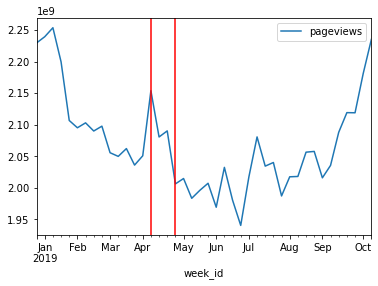

In [55]:
# plot weekly pageview
ax = df_weekly.plot(y="pageviews", kind="line")
# add vertical lines in red according to the start date and end date of the marketing campaign
ax.axvline(campaign_start, color="r")
ax.axvline(campaign_end, color="r")

If you re-used the vertical lines from above, you notice that they might not do the best job in framing the area of the campaign. Move the vertical lines 1 week further apart.

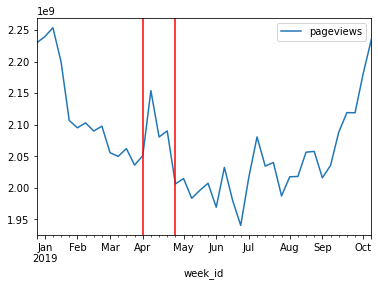

In [59]:
# move the vertical lines so that they frame the campaign date range
ax = df_weekly.plot(y="pageviews", kind="line")
# add vertical lines in red according to the start date and end date of the marketing campaign
campaign_start = pd.to_datetime("2019-04-01")
ax.axvline(campaign_start, color="r")
ax.axvline(campaign_end, color="r")

Better! After lowering the resolution to weekly precision, it is easier for us to detect the campaign. Visually, it did result in an increase in pageviews. In order for us to conclude, however, whether the campaign was a success or not, we need to estimate the impact.

<!-- Estimating the impact of something that has happened in the past always comes with a lot of uncertainties. There are mulitple approaches to tackle that problem, none of them, however, allow you to draw conclusions about causality. -->

One approach to estimate the impact is to (1.) estimate the number of pageviews company J would have had without the campaign to then (2.) subtract the actual observed pageviews from that estimate.
In the following, you are going to tackle (1.) using Linear Regression. Linear Regression allows us to fit a line through the observed data points. That line can serve as an estimate for (1.).

## 2. Estimate Pageviews without campaign

In your first attempt, you are trying to estimate the number of weekly pageviews as a linear function dependent on time. 

That is: $\hat{pageviews_t} = \hat{const} + t*\hat{time},    t \epsilon \{1, \dots, T\}$

You will be using OLS to find your best estimate for the unknown $time$ and $const$ coefficients. 

Before you start though, you need to create a time variable. Datetime objects are extremely useful in general, but they don't allow us to run a regression. In other words, you need to convert the datetime x-axis to a numerical one. The most straightforward way to achieve this is to just add a column with incremental integers, starting from 1.

**I. Create time variable $t$**

In [60]:
df_weekly.head(10)

,pageviews
week_id,
2018-12-31,2229451188
2019-01-07,2239288163
2019-01-14,2253536634
2019-01-21,2199428967
2019-01-28,2106553018
2019-02-04,2095006674
2019-02-11,2102802115
2019-02-18,2089880488
2019-02-25,2097551494


In [61]:
# create time variable as a new column `t` 
# Make sure `df_weekly` is sorted by `week_id` ascending.
df_weekly["t"] = range(1, len(df_weekly)+1)

**II. Create constant**

*Running OLS using the statsmodels package requires us to manually create a constant if we want it to be part of the regression*

In [63]:
# create constant as a new column `const`
df_weekly["const"] = 1

**III. Run OLS and show summary**

In [84]:
# Run OLS
x = df_weekly[["const", "t"]]
y = df_weekly["pageviews"]
fit = sm.OLS(y, x).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.829
Date:                Mon, 07 Sep 2020   Prob (F-statistic):             0.0574
Time:                        16:47:22   Log-Likelihood:                -820.07
No. Observations:                  42   AIC:                             1644.
Df Residuals:                      40   BIC:                             1648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.112e+09   2.35e+07     89.803      0.000    2.06e+09    2.16e+09
t          -1.865e+06   9.53e+05     -1.957      0.057   -3.79e+06    6.13e+04
==============================================================================
Omnibus:                        6.177   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.380
Skew:                           0.870   Prob(JB):                       0.0679
Kurtosis:                       3.213   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:

# Interpret the results in a few sentences
# The effect of of time is negative but extremely small. The R2 is 
# also quite small, indicating there is probably little influence of 
# time on the pageviews

**IV. Plot weekly pageviews incl. fitted line**

Plot the same graph as above but add the new fitted line

In [71]:
# Create new column in df with 'predicted pageviews' using the linear regression from above
df_weekly["predicted pageviews"] = fit.predict(x)

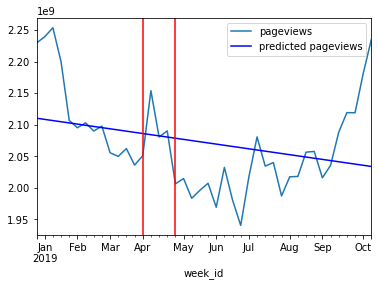

In [101]:
# plot weekly pageview and predicted pageviews
# add vertical lines in red according to the start date and end date of the marketing campaign
ax = df_weekly.plot(y="pageviews", kind="line")
df_weekly.plot(y="predicted pageviews", kind="line", ax=ax, color="blue")
ax.axvline(campaign_start, color="r")
ax.axvline(campaign_end, color="r")

From reading the Regression output you should have already anticipated quite a bad result, but looking at it confirms that the model you chose is probably not the best one. 

Looking at the time-series, you might be better off fitting a quadratic line.

## 2.1. Fit quadratic line

$\hat{pageviews_t} = \hat{const} + t*\hat{time} + t^2*\hat{time^2}$

**I. Add squared time variable**

In [76]:
# add squared time variable
df_weekly["t_squared"] = df_weekly["t"] ** 2
df_weekly.head()

,pageviews,t,const,predicted pageviews,t_squared
week_id,,,,,
2018-12-31,2229451188,1,1,2.110144e+09,1
2019-01-07,2239288163,2,1,2.108279e+09,4
2019-01-14,2253536634,3,1,2.106415e+09,9
2019-01-21,2199428967,4,1,2.104550e+09,16
2019-01-28,2106553018,5,1,2.102685e+09,25


In [100]:
# Rerun OLS
x_2 = df_weekly[["const", "t", "t_squared"]]
y_2 = df_weekly["pageviews"]
fit_2 = sm.OLS(y_2, x_2).fit()
fit_2.summary()
# Run OLS

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     56.43
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           3.08e-12
Time:                        16:59:21   Log-Likelihood:                -793.45
No. Observations:                  42   AIC:                             1593.
Df Residuals:                      39   BIC:                             1598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.261e+09   1.95e+07    115.709      0.000    2.22e+09     2.3e+09
t          -2.214e+07    2.1e+06    -10.567      0.000   -2.64e+07   -1.79e+07
t_squared   4.716e+05   4.73e+04      9.979      0.000    3.76e+05    5.67e+05
==============================================================================
Omnibus:                        7.152   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                5.908
Skew:                           0.840   Prob(JB):                       0.0521
Kurtosis:                       3.745   Cond. No.                     2.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Compare the results to the first OLS summary
# The R2 is strong now

**IV. Plot weekly pageviews incl. fitted line**

Plot the graph from above (including the first fitted line) and add the quadratic line

In [102]:
# Create new column in df with new 'predicted pageviews'
df_weekly["pred_2"] = fit_2.predict(x_2)

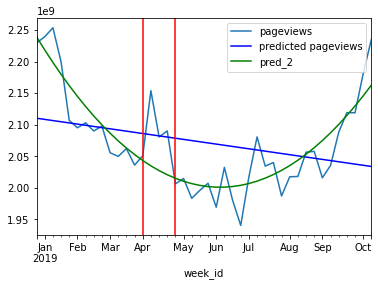

In [103]:
# plot weekly pageviews, predicted pageviews and the predicted pageviews using the quadratic line
# use different colors to distinguish the different lines
# add vertical lines in red according to the start date and end date of the marketing campaign

df_weekly.plot(y="pred_2", kind="line", ax=ax, color="green")
ax.get_figure()

Much better. 
You are going to continue your analysis using the quadratic line as the estimate. Hence, you interpret the quadratic line as *weekly pageviews company J would have gotten without the campaign*. This helps you in isolating the impact that the campaign might have had.

## 3. Compute difference in estimated (predicted) pageviews and actual pageviews

Using that data, you can now easily compute the differences between the 'predicted' pageviews compared to the actual pageviews. You will attribute that difference to the Marketing campaign.

In [109]:
df_weekly.reset_index(inplace=True)

In [113]:
# filter the df for only the relevant rows that were affected by the marketing campaign 
# and the columns needed for analysis
diff = df_weekly.loc[(df_weekly["week_id"] > campaign_start) & (df_weekly["week_id"] < campaign_end)]
diff = diff.drop(columns=["predicted pageviews"]).reset_index(drop=True)
diff.head()

,week_id,pageviews,t,const,t_squared,pred_2
0,2019-04-08,2153783320,15,1,225,2.034676e+09
1,2019-04-15,2080427928,16,1,256,2.027152e+09
2,2019-04-22,2090046150,17,1,289,2.020571e+09


In [118]:
# compute the absolute difference in pageviews for each of the three weeks as a new column `diff`
diff["diff"] = diff["pageviews"] - diff["pred_2"]
diff

,week_id,pageviews,t,const,t_squared,pred_2,diff
0,2019-04-08,2153783320,15,1,225,2.034676e+09,1.191070e+08
1,2019-04-15,2080427928,16,1,256,2.027152e+09,5.327569e+07
2,2019-04-22,2090046150,17,1,289,2.020571e+09,6.947473e+07


In [121]:
# Generate the total difference across the entire 3 weeks and print a sentence
total = diff["diff"].sum()
print(total)
# How many additional pageviews can be attributed to the campaign using your model?
# 241 million extra

241857419.0598526


In [125]:
# Generate the relative increase over 3 weeks and print a sentence (in %, 2 positions after the decimal)
perc = (total / diff["pred_2"].sum()) * 100
print(f"{perc:.2f}% increase over 3 weeks.")

3.98% increase over 3 weeks.


# 4. Calculate ROI

As said above, company J has worked with a consultancy in the past and they provided the following useful estimates:

On a weekly basis, 
- users view on average **17.3 pages**
- the conversion rate for unique users overall is **0.1%**
- purchasing users only did so **once** in that week
- the average purchase amount is **48.9 EUR**
- company J's profit margin is **10%** on average

From the Marketing team, you know that they spent **75,000 EUR** on the entire campaign.

Using these figures, you can attempt to calculate the return on investment by assuming they apply to the marketing campaign weeks.

**I. Set variables for the data provided by the consultancy**

In [127]:
pvpu = 17.3 # pageviews per user
cr = 0.001 # conversion rate
rev = 48.9 # average revenue per purchase
margin = 0.1 # profit margin

In [134]:
# calculate the average profit per purchase
profit = margin * rev
print(f"EUR {profit:.2f}")

EUR 4.89


**II. Estimate conversion using both the predicted and actual pageviews**

In [140]:
# re-use the dataframe from the previous section
# add a new column `conversions` with estimated weekly conversions using the actual pageview numbers
diff["conversions"] = (diff["pageviews"] / pvpu) * cr
diff

,week_id,pageviews,t,const,t_squared,pred_2,diff,conversions,pred_conversions,diff_profit
0,2019-04-08,2153783320,15,1,225,2.034676e+09,1.191070e+08,124496.145665,2.034676e+06,582433.234477
1,2019-04-15,2080427928,16,1,256,2.027152e+09,5.327569e+07,120255.949595,2.027152e+06,260518.100744
2,2019-04-22,2090046150,17,1,289,2.020571e+09,6.947473e+07,120811.916185,2.020571e+06,339731.443981


In [141]:
# add a new column `pred_conversions` with predicted weekly conversions
diff["pred_conversions"] = (diff["pred_2"] / pvpu) * cr
diff

,week_id,pageviews,t,const,t_squared,pred_2,diff,conversions,pred_conversions,diff_profit
0,2019-04-08,2153783320,15,1,225,2.034676e+09,1.191070e+08,124496.145665,117611.347924,582433.234477
1,2019-04-15,2080427928,16,1,256,2.027152e+09,5.327569e+07,120255.949595,117176.430218,260518.100744
2,2019-04-22,2090046150,17,1,289,2.020571e+09,6.947473e+07,120811.916185,116796.035669,339731.443981


**III. Estimate the additional profit attributable to the Marketing campaign**

In [142]:
# add a new column `diff_profit` with the difference in profit 
# between the estimated conversion and estimated predicted conversion
diff["diff_profit"] = ((diff["conversions"] * profit) 
                       - (diff["pred_conversions"] * profit))
diff

,week_id,pageviews,t,const,t_squared,pred_2,diff,conversions,pred_conversions,diff_profit
0,2019-04-08,2153783320,15,1,225,2.034676e+09,1.191070e+08,124496.145665,117611.347924,33666.660952
1,2019-04-15,2080427928,16,1,256,2.027152e+09,5.327569e+07,120255.949595,117176.430218,15058.849754
2,2019-04-22,2090046150,17,1,289,2.020571e+09,6.947473e+07,120811.916185,116796.035669,19637.655721


In [143]:
# Calculate the sum of the additional profit over the three weeks
total_profit = diff["diff_profit"].sum()
# print a sentence that states the estimated increase in profit due to the campaign
print(f"Total increase in profit due campaign is EUR {total_profit:.2f}")

Total increase in profit due campaign is EUR 68363.17


# 5. Conclusion

In [ ]:
# Write down your conclusion and your recommendation to the product team
"""
There was a substantial increase in profit, however, it was less than the 
total spend on the campaign. 
"""

**Discussion**

This analysis was based on many assumptions. Take some time to go through each of these assumptions and discuss their validity:

Some of the crucial assumptions we made were:
- Data points from the consultancy
    - If the data points they provided was based on historical data from a time period before the marketing campaign started, what are potential risks when accepting them at face value?
    - When applying the data points to 'newly acquired' users, what are potential biases?
- Predicted Pageviews as a result of a linear regression
    - How accurate is it to use the fitted quadratic line as a prediction for how many pageviews company J might have had without the campaign?
    - How can you remedy some of these problems?
    
Think of other assumptions you made and discuss them as if you were to write a detailed analysis report to be shared with all employees in the company